## This program is the main function that runs the simulation such that
1. Compares raw job list with an altered job list. The comparison can be turned off so it only runs on raw job lists. <br>
2. Outputs two csv files for data, one from unaltered job list (called the Benchmark), another from altered joblist (called the Experiment). If the Monte-Carlo run is more than 1, only the last run will be saved. <br>
3. Provides two time series (benchmark and experiment) with time, number of forklifts at different status, number of them waiting on the each dropping off point, and the number of them on all dropping off points together. <br>
4. Provides a visualization and can save all the figrues for animation purposes. Read the specific part for detail. <br>

#  <font color=red>READ BEFORE YOU RUN THE CODE </font>
0. Run in Jupyter notebook for best result.
1. You need to run the main function at least once to get updated csv files for data analysis.<br>
2. If you want to test your own joblist optimizing function, change the function <font color=blue>order_tasks(job_list, WAREHOUSE_DIM) </font> at line 60 or so in the <font color=blue>main() </font> function block.
3. Global variables are in the control panel. Change them if needed. <br>
4. The arrow plotting part needs some better improvements, you can run that but it may not give what you want.<br>
5. There are several black boxes and private functions, private variables in the file. Try not to alter them as it might break the code. <br>

Hansen 07/17/2020 IMA Bootcamp

In [1]:
import itertools
import pandas as pd
import numpy as np
#from simulation_w_list import Simulation as Sim_list
from simulation_greedy import Simulation as Sim_greedy
from simulation import Simulation as Sim_original
#from Order_runs_engine import Reorder_engine
from scipy import stats

#%matplotlib notebook
%matplotlib inline
from ipywidgets import *
import matplotlib.pyplot as plt
import copy
import ast
import os
import time

# Simulation Part

In [2]:
"""
Control Panel. Change global variables here.
"""
# var 1: order of the forklifts jobs
# var 2: tasks within each job for each forklift
# try to minimize time

WAREHOUSE_DIM = 12  # size of warehouse
N_FORKLIFTS = 20  #number of forklifts available
RECEIVING = [0, 0]  # location of receiving
SHIPPING = [WAREHOUSE_DIM-1, WAREHOUSE_DIM-1]  # location of shipping
LAB = [0, WAREHOUSE_DIM-1]  # location of lab

IF_RUN_BENCHMARK = True
IF_RUN_EXPERIMENT = True


OUTPUT_TO_CSV_BM = True # whether we want a csv output file for benchmark
OUTPUT_TO_CSV_EP = True # whether we want a csv output file for experiment
IF_PRINT = False # if we want the simulation to print how much job is done
N_JOBS = 350 # number of jobs
N_RUNS = 100 # number of runs, for Monte-Carlo purpose
weight_preference = 1 #1 if no preference towards type, 0 if only a preference towards type

outputfile_bm = 'test_run_bm.csv' # saving the benchmark result
outputfile_ep = 'test_run_ep.csv' # saving the experimental result

In [3]:
def main():
    """
    Runs the Monte-Carlo code, generates total running time in order to
    compare a raw job list with an optimized job list.
    It also saves the running data to a csv file (Can be turned off).
    
    
    Input: nothing
    
    Output: a list of 2 (sub)lists: 
        -The 0th sub-list records the benchmark using a randomly generated joblist
        -The 1st sub_list records the pointwise-optimized joblist
    """
    print("Total number of runs:", N_RUNS)
    print("Total number of jobs for each run:", N_JOBS)
    print("Warehouse dimension is:", WAREHOUSE_DIM)
    print("The number of forklift is:", N_FORKLIFTS)
    print("Whether running a parallel experiment:", IF_RUN_EXPERIMENT)

    run_time_data = run_simulation(n_runs = N_RUNS,
                                   output_file_bm = outputfile_bm,
                                   output_file_ep = outputfile_ep,
                                   if_run_benchmark = IF_RUN_BENCHMARK,
                                   if_run_experiment = IF_RUN_EXPERIMENT,
                                   _if_print = IF_PRINT,
                                   _output_to_csv = [OUTPUT_TO_CSV_BM,OUTPUT_TO_CSV_EP],
                                   _receiving = RECEIVING,
                                   _shipping = SHIPPING,
                                   _lab = LAB,
                                   _warehouse_dim = WAREHOUSE_DIM,
                                   _n_forklifts = N_FORKLIFTS,
                                   _n_jobs = N_JOBS)
    print("Benchmark run time: ", run_time_data[0])
    print("Experiment run time: ", run_time_data[1])
        
    return run_time_data
    
def run_simulation(n_runs,
                   output_file_bm,
                   output_file_ep,
                   if_run_benchmark,
                   if_run_experiment,
                   _if_print,
                   _output_to_csv,
                   _receiving,
                   _shipping,
                   _lab,
                   _warehouse_dim,
                   _n_forklifts, 
                   _n_jobs):
    """
    Black box. Do not alter stuff except for changing the optimized job list.
    """
    Benchmark_time_data = np.zeros(n_runs)
    Experiment_time_data = np.zeros(n_runs)
    
    
    for run_number in range(0,n_runs):
        raw_job_list_and_type = [generate_random_job(warehouse_dim = _warehouse_dim) for k in range(_n_jobs)]
        sorted_job_list_and_type = sorted(raw_job_list_and_type, key = lambda x: len(x[0]), reverse = True)
        
        raw_job_list = [raw_job_list_and_type[item][0] for item in range(_n_jobs)]
        raw_job_type = [raw_job_list_and_type[item][1] for item in range(_n_jobs)]

        sorted_job_list = [sorted_job_list_and_type[item][0] for item in range(_n_jobs)]
        sorted_job_type = [sorted_job_list_and_type[item][1] for item in range(_n_jobs)]
        
        #for sorted
        job_lengths = [0 for k in range(_n_jobs)]
        for k in range(_n_jobs):
            job_lengths[k] = len(sorted_job_list[k])
            
        """ This boxed part below is the place that you can change"""
        ######### This is where you optimize joblist ##########
        #raw_job_assign = shuffle_job_index(n_forklifts = N_FORKLIFTS, n_jobs=N_JOBS)
        
        forklift_preference_list = define_forklift_preference(job_type = raw_job_type)
        
        #job_list = order_tasks(sorted_job_list, WAREHOUSE_DIM)
        #job_type = sorted_job_type
        
        sorted_job_list = order_tasks(job_list = sorted_job_list, WAREHOUSE_DIM = _warehouse_dim)
        sorted_job_type = sorted_job_type
        
        #print('job_list',job_list)
        #print('job_type',job_type)
        #print('forklift_preference_list', forklift_preference_list)
        
        if if_run_benchmark == True:
            if run_number < n_runs - 1:
                test_benchmark = Sim_original(warehouse_x_dim=_warehouse_dim, 
                                  warehouse_y_dim=_warehouse_dim,
                                  receiving = _receiving,
                                  shipping = _shipping,
                                  lab = _lab,
                                  n_forklifts=_n_forklifts,
                                  forklift_job_lists=raw_job_list,
                                  #job_assign_list = job_assignment,
                                  output_to_csv = False, # boolean, we want to skip those
                                  if_print = _if_print) # boolean
                Benchmark_time_data[run_number] = test_benchmark.run(output_file_bm)
            elif run_number == n_runs - 1: 
                test_benchmark = Sim_original(warehouse_x_dim=_warehouse_dim, 
                                  warehouse_y_dim=_warehouse_dim,
                                  receiving = _receiving,
                                  shipping = _shipping,
                                  lab = _lab,
                                  n_forklifts=_n_forklifts,
                                  forklift_job_lists=raw_job_list,
                                  #job_assign_list = job_assignment, #list(range(_n_forklifts)),
                                  output_to_csv = _output_to_csv[0], # we want to output only the last one
                                  if_print = _if_print) # boolean
                Benchmark_time_data[run_number] = test_benchmark.run(output_file_bm)
        
        #Set up the simulation with a CHANGED joblist
        """
        RUNNING THE EXPERIMENT USING THE MODIFIED ENGINE
        YOU NEED TO FEED IN A LIST
        """ 
        if if_run_experiment == True:
            #print("n_runs = ", run_number)
            if run_number < n_runs - 1:
                test_experiment = Sim_greedy(warehouse_x_dim=_warehouse_dim, 
                                  warehouse_y_dim=_warehouse_dim,
                                  receiving = _receiving,
                                  shipping = _shipping,
                                  lab = _lab,
                                  n_forklifts=_n_forklifts,
                                  forklift_preference_list = forklift_preference_list,
                                  forklift_job_lists=sorted_job_list,
                                  job_lengths = job_lengths, 
                                  job_type = sorted_job_type,
                                  weight_preference = weight_preference,
                                  job_assign_list = None, #job_assignment,
                                  output_to_csv = False,#_output_to_csv, # boolean
                                  if_print = _if_print) # boolean
                Experiment_time_data[run_number] = test_experiment.run(output_file_ep)
            elif run_number == n_runs - 1:
                test_experiment = Sim_greedy(warehouse_x_dim=_warehouse_dim, 
                                  warehouse_y_dim=_warehouse_dim,
                                  receiving = _receiving,
                                  shipping = _shipping,
                                  lab = _lab,
                                  n_forklifts=_n_forklifts,
                                  forklift_preference_list = forklift_preference_list,
                                  forklift_job_lists=sorted_job_list,
                                  job_lengths = job_lengths,
                                  job_type = sorted_job_type,
                                  weight_preference = weight_preference,
                                  job_assign_list = None, #job_assignment,
                                  output_to_csv = _output_to_csv[1],#_output_to_csv, # boolean
                                  if_print = _if_print) # boolean
                Experiment_time_data[run_number] = test_experiment.run(output_file_ep)
        
        """
        RUNNING THE EXPERIMENT USING THE ORIGINAL ENGINE
        """        
        
    return [Benchmark_time_data, Experiment_time_data]

def shuffle_job_index(n_forklifts = N_FORKLIFTS, n_jobs=N_JOBS):
    base = np.arange(N_FORKLIFTS)
    np.random.shuffle(base)
    job_assignment = np.random.choice(range(N_FORKLIFTS),N_JOBS-N_FORKLIFTS)
    result = np.concatenate((base, job_assignment), axis=None)
    np.random.shuffle(result)
    return list(result)

def generate_random_job(warehouse_dim = WAREHOUSE_DIM, 
                        receiving = RECEIVING, 
                        shipping = SHIPPING, 
                        lab = LAB):
    job_length = 1 + np.random.randint(5) #1 + np.random.randint(3) # number of tasks
    job = np.random.randint(warehouse_dim, size=job_length*2)
    for i in range(0,job_length-1):
        while (job[2*i]==receiving[0] and job[2*i+1]==receiving[1]) or (job[2*i]==shipping[0] and job[2*i+1]==shipping[1]) or (job[2*i]==lab[0] and job[2*i+1]==lab[1]):
            job = np.random.randint(warehouse_dim, size=job_length*2)
    destination = [receiving, shipping, lab][np.random.choice([0,1,2])]
    if destination == receiving:
        job = np.insert(job, 0, destination)
    else:
        job = np.append(job, destination)
    job = job.reshape(job_length + 1, 2)
    return [job,destination]

def define_forklift_preference(job_type,
                              n_forklifts = N_FORKLIFTS,
                              receiving = RECEIVING,
                              shipping = SHIPPING,
                              lab = LAB):
    N_JOBS = len(job_type)
    num_receiving_jobs = 0.0
    num_shipping_jobs = 0.0
    num_lab_jobs = 0.0
    for i in range(0,N_JOBS):
        if (job_type[i] == RECEIVING):
            num_receiving_jobs += 1
        elif (job_type[i] == SHIPPING):
            num_shipping_jobs += 1
        elif (job_type[i] == LAB):
            num_lab_jobs += 1
    
    #which forklift prefers each of the three regions: in proportion to R/S/L
    num_forklifts_lab = max(int(np.floor((num_receiving_jobs / N_JOBS) * n_forklifts)),1)
    num_forklifts_shipping = max(int(np.floor((num_shipping_jobs / N_JOBS) * n_forklifts)),1)
    num_forklifts_receiving = n_forklifts - num_forklifts_lab - num_forklifts_shipping
    
    
    forklift_preference_list = []
    for i in range(0,num_forklifts_receiving):
        forklift_preference_list.append(receiving)
    for i in range(0,num_forklifts_shipping):
        forklift_preference_list.append(shipping)
    for i in range(0,num_forklifts_lab):
        forklift_preference_list.append(lab)
        
    return forklift_preference_list


####################################################################################
####################################################################################
####################################################################################
### Below are the candidates for optimizing the job list ###########################
def order_tasks(job_list, WAREHOUSE_DIM):
    import copy
    """
    This orders the tasks within a certain job to minimize distance
    This does not take into account the original location of the forklift
    NOTE: distance \neq time since time had an error
    """
    
    for i in range(0,len(job_list)): #optimize each job
        job = copy.copy(job_list[i]) #consider a single job
        N_TASKS = len(job)-1 #number of tasks
        
        distance = WAREHOUSE_DIM*len(job)+1 #make this large, this is what we need to beat
        if all(job[0] == [0,0]): #change this to RECEIVING
            for perm in itertools.permutations(job[1:],N_TASKS): #potential permutations
                this_dist = 0 #the distance for this permutation
                for j in range(1,N_TASKS-1):
                    this_dist += abs(perm[j][0]-perm[j+1][0]) + abs(perm[j][1]-perm[j+1][1]) #add distance between tasks
                this_dist += abs(perm[0][0] - job[0][0]) + abs(perm[0][1] - job[0][1]) #add distance to delivery point
                
                if this_dist < distance: #better permutation
                    distance = this_dist
                    job_list[i][1:N_TASKS+1] = list(perm)
        else:
            for perm in itertools.permutations(job[:N_TASKS],N_TASKS): #potential permutations
                this_dist = 0 #the distance for this permutation
                for j in range(0,N_TASKS-1):
                    this_dist += abs(perm[j][0]-perm[j+1][0]) + abs(perm[j][1]-perm[j+1][1]) #add distance between tasks
                this_dist += abs(perm[N_TASKS-1][0] - job[N_TASKS][0]) + abs(perm[N_TASKS-1][1] - job[N_TASKS][1]) #add distance to delivery point
                    
                if this_dist < distance: #better permutation
                    distance = this_dist
                    job_list[i][0:N_TASKS] = list(perm)
    return job_list

In [4]:
start_time = time.time()
run_time_data = main()
print('It took %i seconds to run' %(time.time()-start_time))


Total number of runs: 100
Total number of jobs for each run: 350
Warehouse dimension is: 12
The number of forklift is: 20
Whether running a parallel experiment: True
Benchmark run time:  [1546. 1526. 1567. 1508. 1602. 1514. 1480. 1520. 1501. 1526. 1519. 1479.
 1575. 1539. 1524. 1484. 1527. 1536. 1537. 1512. 1528. 1473. 1525. 1510.
 1511. 1501. 1518. 1482. 1575. 1564. 1518. 1509. 1513. 1515. 1510. 1503.
 1458. 1519. 1458. 1534. 1565. 1519. 1543. 1468. 1533. 1517. 1510. 1560.
 1495. 1526. 1489. 1565. 1547. 1540. 1537. 1491. 1570. 1520. 1538. 1555.
 1528. 1559. 1571. 1550. 1519. 1543. 1537. 1529. 1527. 1498. 1532. 1600.
 1465. 1501. 1520. 1556. 1523. 1562. 1475. 1494. 1510. 1530. 1507. 1479.
 1522. 1524. 1545. 1516. 1555. 1488. 1503. 1494. 1524. 1542. 1535. 1569.
 1557. 1535. 1551. 1575.]
Experiment run time:  [1488. 1417. 1466. 1446. 1496. 1457. 1414. 1430. 1436. 1453. 1471. 1410.
 1500. 1439. 1478. 1429. 1441. 1475. 1469. 1434. 1485. 1436. 1427. 1427.
 1427. 1424. 1464. 1431. 1475. 1490

# Primitive Data Analysis, No CSV Needed

The benchmark average is  1524.84 The benchmark std is  29.69535990689454
The experiment average is  1449.7 The experiment std is  27.401277342488985
The p-value from Welch's t-test is 6.137996243580848e-45
Difference is significant, with efficiency change on avg 4.928 %


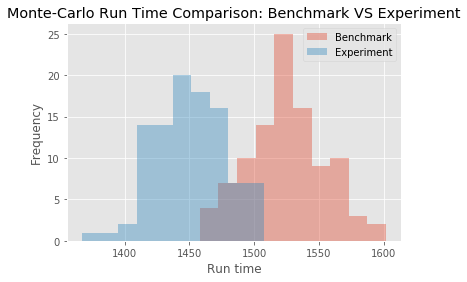

In [5]:
avg_bm = np.average(run_time_data[0])
std_bm = np.std(run_time_data[0])
print("The benchmark average is ", avg_bm, "The benchmark std is ", std_bm)

avg_ep = np.average(run_time_data[1])
std_ep = np.std(run_time_data[1])
print("The experiment average is ", avg_ep, "The experiment std is ", std_ep)

# perform a Welch's t-test, assuming different variations from both samples
t_test_result = stats.ttest_ind(run_time_data[0],run_time_data[1], equal_var = False)
fail_reject_null_hypothesis = (t_test_result[1] > 0.05)
print("The p-value from Welch\'s t-test is", t_test_result[1])
if fail_reject_null_hypothesis:
    print("Difference is insignificant, fail to reject the null hypothesis")
else:
    print("Difference is significant, with efficiency change on avg %.3f %%" 
          % ((avg_bm-avg_ep)/avg_bm*100))

plt.style.use('ggplot')
plt.figure()
plt.hist(run_time_data[0], alpha = 0.4, label = 'Benchmark')
plt.hist(run_time_data[1], alpha = 0.4, label = 'Experiment')
plt.legend(loc='upper right')
plt.title('Monte-Carlo Run Time Comparison: Benchmark VS Experiment')
plt.xlabel('Run time')
plt.ylabel('Frequency')
plt.show()

# Need A .csv File to work with

In [6]:
# load the data, and check if it is successfully loaded
try:
    df_bm = pd.read_csv('test_run_bm.csv')
    print(df_bm.tail(10))
    print(len(df_bm)/N_FORKLIFTS)

    df_ep = pd.read_csv('test_run_ep.csv')
    print(df_ep.tail(10))
    print(len(df_ep)/N_FORKLIFTS)
except:
    print("There are no csv files in current your folder.",
          "Go back to the control panel to make sure you have some csv files to begin with")

       time        name current_destination last_loc    status  \
31490  1574  Forklift10             [0, 11]  [8, 11]  complete   
31491  1574  Forklift11              [7, 4]  [11, 3]  complete   
31492  1574  Forklift12             [7, 11]  [10, 7]  complete   
31493  1574  Forklift13            [11, 11]  [5, 10]  complete   
31494  1574  Forklift14              [3, 9]   [7, 8]  complete   
31495  1574  Forklift15             [0, 11]   [1, 6]  complete   
31496  1574  Forklift16            [11, 11]   [5, 7]  complete   
31497  1574  Forklift17             [9, 11]  [5, 11]  complete   
31498  1574  Forklift18             [0, 11]  [10, 5]  complete   
31499  1574  Forklift19             [0, 11]   [2, 9]  complete   

       next_update_time  
31490       1480.735626  
31491       1544.253960  
31492       1558.193715  
31493       1571.488432  
31494       1533.815566  
31495       1533.871732  
31496       1519.092538  
31497       1506.464052  
31498       1459.677370  
31499       1

# Distance Covered

In [7]:

import json

df_bm_col = pd.read_csv('test_run_bm.csv', usecols=["name","current_destination"])
df_ep_col = pd.read_csv('test_run_ep.csv', usecols=["name","current_destination"])


def compute_distance_by_forklift(forklift_index, df_col):
    df_index = df_col.loc[df_col['name']=='Forklift'+str(forklift_index)]

    index_list = df_index['current_destination'].values.tolist()
    #print(bm_zero_list)

    destinations = [[0,0] ]
    for i in range(len(index_list)-1):
        if index_list[i+1] != index_list[i]:
            destinations.append(json.loads(index_list[i]))

    destinations.append(json.loads(index_list[len(index_list)-1]))
    #print(destinations)

    finaldistance = 0
    for i in range(len(destinations)-1):
        finaldistance += abs(destinations[i+1][0]-destinations[i][0])+abs(destinations[i+1][1]-destinations[i][1])

    return finaldistance

def compute_total_distance(n_forklifts, df_col):
    totaldistance = 0
    for i in range(n_forklifts):
        totaldistance += compute_distance_by_forklift(i, df_col)
        #print('Forklift ', i, 'covered the following distance ', compute_distance_by_forklift(i, df_col))
    return totaldistance
       
total_distance_bm = compute_total_distance(N_FORKLIFTS, df_bm_col)
print('Total distance for the benchmark is ', total_distance_bm)

total_distance_ep = compute_total_distance(N_FORKLIFTS, df_ep_col)
print('Total distance for the experiment is ', total_distance_ep)


percent = 100*float(total_distance_bm - total_distance_ep)/total_distance_bm
print('Percent change ep vs. bm is ', percent )


Forklift  0 covered the following distance  610
Forklift  1 covered the following distance  570
Forklift  2 covered the following distance  547
Forklift  3 covered the following distance  508
Forklift  4 covered the following distance  589
Forklift  5 covered the following distance  568
Forklift  6 covered the following distance  565
Forklift  7 covered the following distance  569
Forklift  8 covered the following distance  551
Forklift  9 covered the following distance  567
Forklift  10 covered the following distance  571
Forklift  11 covered the following distance  595
Forklift  12 covered the following distance  548
Forklift  13 covered the following distance  614
Forklift  14 covered the following distance  542
Forklift  15 covered the following distance  557
Forklift  16 covered the following distance  552
Forklift  17 covered the following distance  578
Forklift  18 covered the following distance  559
Forklift  19 covered the following distance  551
Total distance for the benchma

# Arrow Plot

In [8]:
"""
Plots a vector field at a given global time spot.
Dot: a forklift's last known position
Arrow: pointing from last position to the next position
Arrow colors: green    - traveling
              yellow   - picking
              red      - waiting
              no plot  - complete
"""

def plot_save_vector_graph(data_frame, if_save_fig = False):
    df = data_frame
    isf = if_save_fig # whether you want figures to save or not
    end_time = df["time"].max()
    
    for t in range(0,end_time+1):
        picture = plot_given_time(_data_from_feeder = _feeder(_dataframe = df, _target_time = t),
                              if_save_fig = isf)
    print(type(picture))
        
def plot_given_time(_data_from_feeder, if_save_fig = False):
#    %matplotlib inline
    # saving figure defalt to false
    _time = _data_from_feeder[0]
    _last_loc = _data_from_feeder[1]
    _destination = _data_from_feeder[2]
    _status = _data_from_feeder[3]
    _next_update_time = _data_from_feeder[4]
    
    _last_loc = _last_loc.values.tolist()
    for i in range(len(_last_loc)):
        _last_loc[i] = _str_to_list(_last_loc[i])
    _last_loc = np.array(_last_loc)
    #print(_last_loc)
    
    _destination = _destination.values.tolist()
    for i in range(len(_destination)):
        _destination[i] = _str_to_list(_destination[i])
    _destination = np.array(_destination)
    #print(_destination)
    
    # cast _status into a list _status_list for easier manipulation
    _status_list = _status.values.tolist()
    
    fig = plt.figure(figsize=(10,10))
    #plotting the last location & destination
    plt.scatter(_last_loc[:,0],_last_loc[:,1],s=60)
    plt.scatter(_destination[:,0],_destination[:,1],s=60)
    for i in range(len(_destination)): # iterate thru each forklift
        if _status_list[i] == 'traveling':
            plt.arrow(_last_loc[i,0],_last_loc[i,1],
                      _destination[i,0]-_last_loc[i,0],
                      _destination[i,1]-_last_loc[i,1],
                      head_width = 0.1, 
                      color = 'g')
        elif _status_list[i] == 'picking':
            plt.arrow(_last_loc[i,0],_last_loc[i,1],
                      _destination[i,0]-_last_loc[i,0],
                      _destination[i,1]-_last_loc[i,1],
                      head_width = 0.1, 
                      color = 'y')
        elif _status_list[i] == 'waiting':
            plt.arrow(_last_loc[i,0],_last_loc[i,1],
                      _destination[i,0]-_last_loc[i,0],
                      _destination[i,1]-_last_loc[i,1],
                      head_width = 0.1, 
                      color = 'r')
        elif _status_list[i] == 'complete':
            continue
          

    plt.xlim(-2,WAREHOUSE_DIM+1)
    plt.ylim(-2,WAREHOUSE_DIM+1)
    #plt.axis('scaled')
    plt.title("Time = %i" %_time)
    if if_save_fig == True:
        try:
            plt.savefig('figure/time%i' %_time + '.png')
        except:
            os.makedirs('figure')
            plt.savefig('figure/time%i' %_time + '.png')
    plt.close(fig)
    return fig
        
    
def _str_to_list(_string):
    res = ast.literal_eval(_string) 
    return res

def _feeder(_dataframe,_target_time):
    df = _dataframe
    # slice the time
    _time = _target_time
    
    subframe = df[df['time'] == _time]
    _last_loc = subframe['last_loc']
    _destination = subframe['current_destination']
    _status = subframe['status']
    _next_update_time = subframe['next_update_time']
    
    return[_time,
           _last_loc, 
           _destination, 
           _status, 
           _next_update_time]


In [9]:
"""
Remark: It seems quite cumbersome to make animations inside Jupyter so I simply gave up. One animation method 
can run on my computer but in order for it to run on yours you will need to download some widgets and it is 
quite complicated.
Here is the way around it: I will make it save all the figures, and you can feel free to use 3rd party
software to make a stop motion movie. Recommend qStopMotion.
If you want to run through the data to output ALL plot files for ALL time, uncomment line 10.
If you just want to see a plot at a specific time, uncomment line 11-12.
"""
#plot_save_vector_graph(data_frame = df_ep, if_save_fig = True)
#plot_given_time(_data_from_feeder = _feeder(_dataframe = df_ep, _target_time = 80),
#                              if_save_fig = False)

'\nRemark: It seems quite cumbersome to make animations inside Jupyter so I simply gave up. One animation method \ncan run on my computer but in order for it to run on yours you will need to download some widgets and it is \nquite complicated.\nHere is the way around it: I will make it save all the figures, and you can feel free to use 3rd party\nsoftware to make a stop motion movie. Recommend qStopMotion.\nIf you want to run through the data to output ALL plot files for ALL time, uncomment line 10.\nIf you just want to see a plot at a specific time, uncomment line 11-12.\n'

# Time Series Analysis Part, Need A csv File, Need To Run The Previous Code Block

In [10]:
def get_status_data(_data_from_feeder):
    """read from the feeder (at a given time frame), then produces an numpy of 5 components:
clock time, 
number of forklifts waiting, 
number of forklifts traveling,
number of forklifts picking,
number of forklifts completed the work,
number of forklifts waiting for the dropoff points = 
[time, n_wait, n_travel, n_pick, n_complete, n_wait_dropoff]
    """
    _time = _data_from_feeder[0]
    _last_loc = _data_from_feeder[1]
    _destination = _data_from_feeder[2]
    _status = _data_from_feeder[3]
    _next_update_time = _data_from_feeder[4]
    _length = len(_status)
    
    time = _time
    n_wait = _status[_status == "waiting"].count()
    n_travel = _status[_status == "traveling"].count()
    n_pick = _status[_status == "picking"].count()
    n_complete = _status[_status == "complete"].count()
    
    # change _destination into a np array for vectorized manipulation
    _destination = _destination.values.tolist()
    for i in range(len(_destination)):
        _destination[i] = _str_to_list(_destination[i])
    _destination = np.array(_destination)
    
    # cast _status into a list _status_list for easier manipulation
    _status_list = _status.values.tolist()
    
    n_wait_dropoff = 0 # initialize to 0
    n_wait_lab = 0
    n_wait_ship = 0
    n_wait_receive = 0
    for i in range(_length):
        if_LAB = (_destination[i][0] == LAB[0] and _destination[i][1] == LAB[1])
        if_SHIPPING = (_destination[i][0] == SHIPPING[0] and _destination[i][1] == SHIPPING[1])
        if_RECEIVING = (_destination[i][0] == RECEIVING[0] and _destination[i][1] == RECEIVING[1])
        if if_LAB+if_SHIPPING+if_RECEIVING == True: #either shipping, receiving or lab
            if _status_list[i] == 'waiting':
                n_wait_dropoff += 1
                if if_LAB == True:
                    n_wait_lab += 1
                if if_SHIPPING == True:
                    n_wait_ship += 1
                if if_RECEIVING == True:
                    n_wait_receive += 1
                
    return [time, 
            n_wait, 
            n_travel, 
            n_pick, 
            n_complete, 
            n_wait_dropoff, 
            n_wait_lab, 
            n_wait_ship, 
            n_wait_receive]

#    print(time, n_wait, n_travel, n_pick, n_complete, n_wait_dropoff)
 #   print(_destination, type(_destination))
#    print(_status_list, type(_status_list))

df_bm = pd.read_csv('test_run_bm.csv')
print(df_bm.tail(5))
print(len(df_bm)/N_FORKLIFTS)

time_series_data_bm = np.empty([df_bm["time"].max()+1,9])
time_series_data_bm[-1][:] = [df_bm["time"].max()+1, 0,0,0,N_FORKLIFTS,0,0,0,0]
            
for i in range(0,df_bm["time"].max()):
    time_series_data_bm[i][:] = \
    get_status_data(_data_from_feeder = _feeder(_dataframe = df_bm, _target_time = i))
    
df_ep = pd.read_csv('test_run_ep.csv')
print(df_ep.tail(5))
print(len(df_ep)/N_FORKLIFTS)

time_series_data_ep = np.empty([df_ep["time"].max()+1,9])
time_series_data_ep[-1][:] = [df_ep["time"].max()+1, 0,0,0,N_FORKLIFTS,0,0,0,0]
            
for i in range(0,df_ep["time"].max()):
    time_series_data_ep[i][:] = \
    get_status_data(_data_from_feeder = _feeder(_dataframe = df_ep, _target_time = i))

      time        name current_destination last_loc    status  \
9675   483  Forklift15             [3, 16]   [0, 0]  complete   
9676   483  Forklift16             [3, 15]   [5, 0]  complete   
9677   483  Forklift17             [0, 19]  [8, 15]  complete   
9678   483  Forklift18            [15, 15]  [7, 15]  complete   
9679   483  Forklift19             [0, 19]  [13, 3]  complete   

      next_update_time  
9675        366.058320  
9676        478.951502  
9677        384.508372  
9678        442.629792  
9679        378.781083  
484.0
      time        name current_destination  last_loc    status  \
9355   467  Forklift15             [0, 19]    [5, 6]  complete   
9356   467  Forklift16              [6, 7]    [0, 0]  complete   
9357   467  Forklift17              [3, 3]    [0, 0]  complete   
9358   467  Forklift18            [19, 19]  [11, 15]  complete   
9359   467  Forklift19            [19, 19]   [13, 1]  complete   

      next_update_time  
9355        402.711036  
9356  

# Plotting the time series from a specific csv file

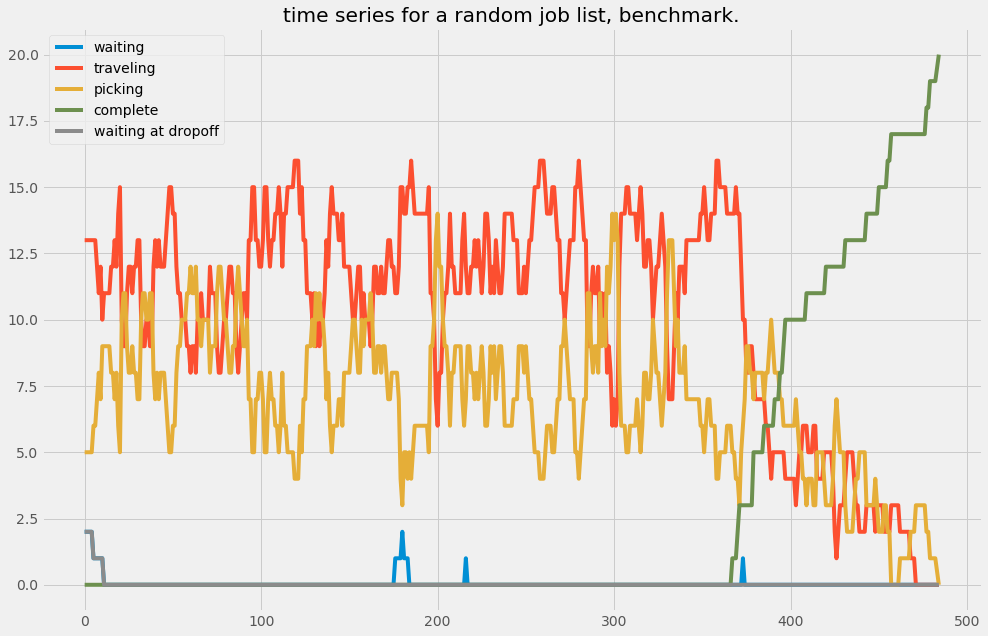

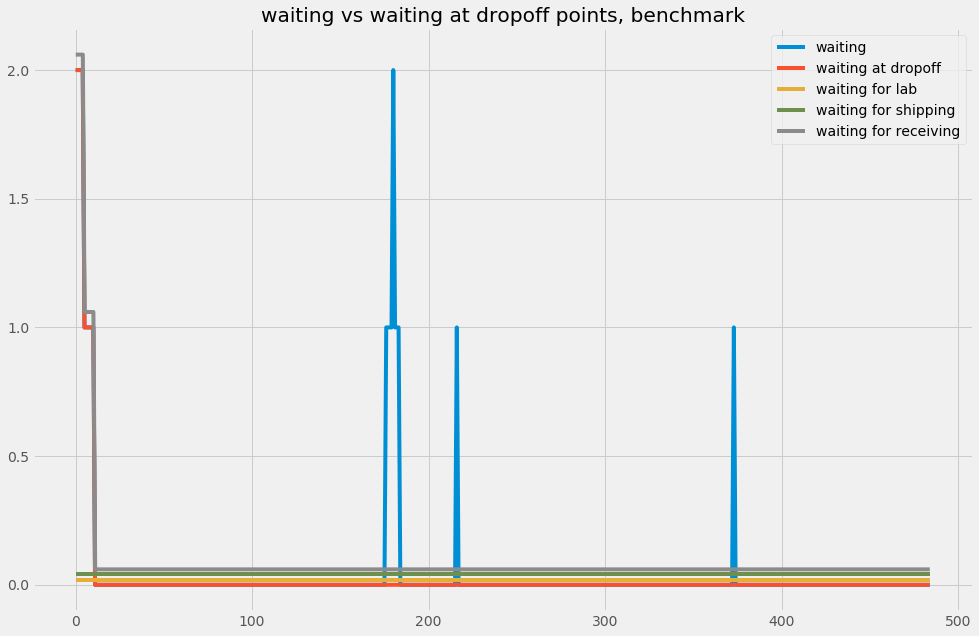

In [11]:
"""
Plotting for the benchmark
"""
plt.style.use('fivethirtyeight')
ts1 = time_series_data_bm
plt.figure(figsize=(15,10))
plt.plot(ts1[:,0],ts1[:,1], label='waiting')
plt.plot(ts1[:,0],ts1[:,2], label='traveling')
plt.plot(ts1[:,0],ts1[:,3], label='picking')
plt.plot(ts1[:,0],ts1[:,4], label='complete')
plt.plot(ts1[:,0],ts1[:,5], label='waiting at dropoff')
plt.title('time series for a random job list, benchmark.')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.plot(ts1[:,0],ts1[:,1], label = 'waiting')
plt.plot(ts1[:,0],ts1[:,5], label = 'waiting at dropoff')
plt.plot(ts1[:,0]+0.02,ts1[:,6]+0.02, label = 'waiting for lab')
plt.plot(ts1[:,0]+0.04,ts1[:,7]+0.04, label = 'waiting for shipping')
plt.plot(ts1[:,0]+0.06,ts1[:,8]+0.06, label = 'waiting for receiving')
plt.title('waiting vs waiting at dropoff points, benchmark')
plt.legend()
plt.show()

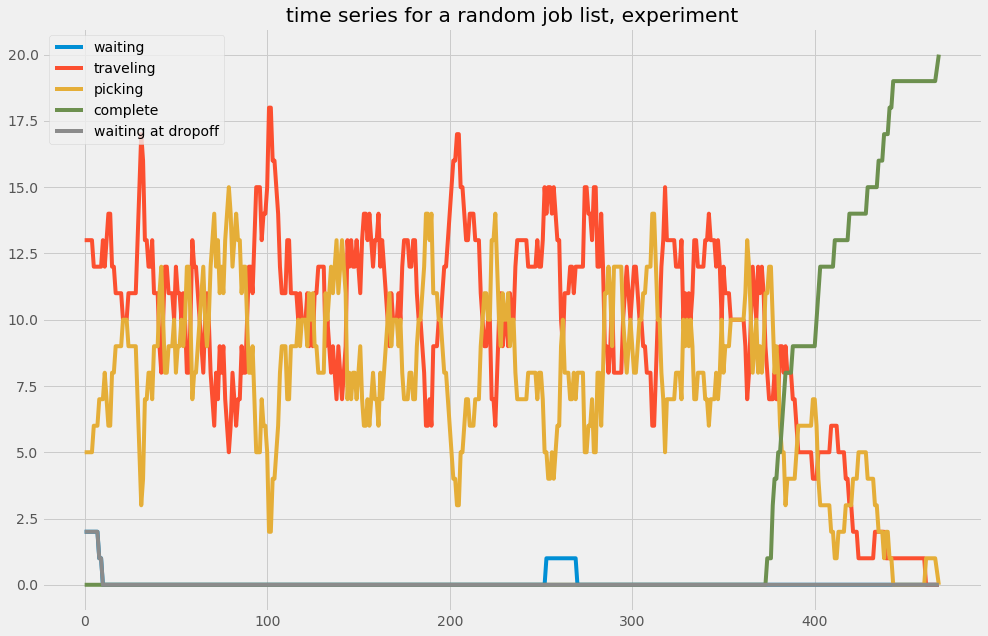

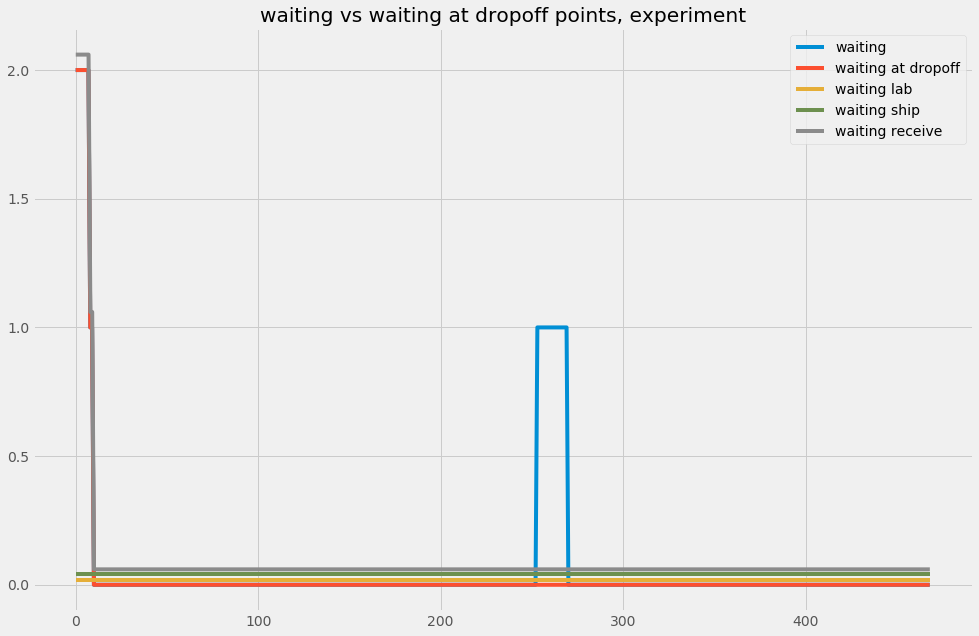

In [12]:
"""
Plotting for the experiment
"""
ts2 = time_series_data_ep
labels = ['waiting', 'traveling', 'picking', 'complete', 'waiting at dropoff']
plt.figure(figsize=(15,10))
plt.plot(ts2[:,0],ts2[:,1], label='waiting')
plt.plot(ts2[:,0],ts2[:,2], label='traveling')
plt.plot(ts2[:,0],ts2[:,3], label='picking')
plt.plot(ts2[:,0],ts2[:,4], label='complete')
plt.plot(ts2[:,0],ts2[:,5], label='waiting at dropoff')
plt.title('time series for a random job list, experiment')
plt.legend()
plt.show()

labels = ['waiting', 'waiting at dropoff', 'waiting lab','waiting ship','waiting receive']
plt.figure(figsize=(15,10))
plt.plot(ts2[:,0],ts2[:,1], label = 'waiting')
plt.plot(ts2[:,0],ts2[:,5], label = 'waiting at dropoff')
plt.plot(ts2[:,0]+0.02,ts2[:,6]+0.02,label = 'waiting for lab')
plt.plot(ts2[:,0]+0.04,ts2[:,7]+0.04, label = 'waiting for shipping')
plt.plot(ts2[:,0]+0.06,ts2[:,8]+0.06, label = 'waiting for receiving')
plt.title('waiting vs waiting at dropoff points, experiment')
plt.legend(labels)
plt.show()

# Crap underneath is irrevelant scratch paper stuff